<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_%EC%A3%BC%EC%8B%9D%EB%B4%87_%EC%85%80%ED%8A%B8%EB%A6%AC%EC%98%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식_봇__강화학습

In [ ]:
!pip install pykrx
!pip install finance-datareader

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50

              Open    High     Low   Close   Volume    Change  Action
Date                                                                 
2020-12-22  361379  364325  352541  352541  1358477 -0.021798       2
2020-12-23  357451  359415  347631  348613  1425317 -0.011142       2
2020-12-24  349104  351559  337320  341248  2076258 -0.021127       2
2020-12-28  343212  353523  318170  327500  7295632 -0.040287       2
2020-12-29  360500  365000  347000  360500  5725005  0.100763       1
...            ...     ...     ...     ...      ...       ...     ..

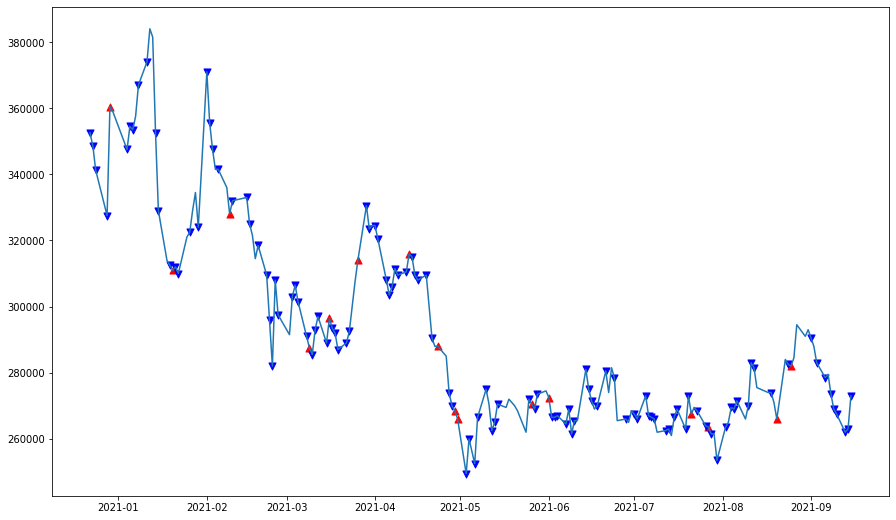

In [3]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
# import pandas_datareader as pdr
# from pykrx import stock
import matplotlib.pyplot as plt

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
  start_date = start
  end_date = end
  sample_code = stock_name
  dataset = fdr.DataReader( sample_code, start = start_date, end = end_date )
  dataset['Close'] = dataset['Close']
  date_split = str(dataset.index[int(train_ratio*len(dataset))])

  return dataset[:date_split], dataset[date_split:], date_split

# 데이터 불러오기
# 주식가격 로딩
import FinanceDataReader as fdr
import datetime
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = '068270'

(train, test, date_split) = dataset_loaderKR(sample_code, start = start_date, end = end_date)


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

# 학습 시키기
env = Environment1(train)
env.reset()

hidden_size = 100
input_size = env.history_t+1
output_size = 3
USE_CUDA = False
LR = 0.001

Q = Q_Network(input_size, hidden_size, output_size)
Q_ast = copy.deepcopy(Q)

if USE_CUDA:
    Q = Q.cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

epoch_num = 50
step_max = len(env.data)-1
memory_size = 200
batch_size = 50
gamma = 0.97

obs, reward, done = env.step(5)

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
show_log_freq = 5

start = time.time()
for epoch in range(epoch_num):
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:
        # select act
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
    print("Epoch %d" % (epoch+1))

# TEST
test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print( sample_code, "결과")
print( "손익결과 $%.2f" % round(test_profits,2) )

if next_action == 2:
	print('하락!')
elif next_action == 1:
	print('증가!')
else:
	print('유지 - 확률 반반!')

buy_dates = test.loc[test['Action'] ==1].index.values
sell_dates = test.loc[test['Action'] ==2].index.values

buy_close = test.loc[test['Action'] ==1, 'Close'].values
sell_close = test.loc[test['Action'] ==2, 'Close'].values

fig = plt.figure(figsize=(15,9))

plt.plot(test['Close'])
plt.scatter(buy_dates, buy_close, label='skitscat', color='red', s=50, marker="^")
plt.scatter(sell_dates, sell_close, label='skitscat', color='blue', s=50, marker="v")
plt.show()

In [ ]:
Q.forward

<bound method Q_Network.forward of Q_Network(
  (fc_val): Sequential(
    (0): Linear(in_features=91, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)>

In [4]:
test

,Open,High,Low,Close,Volume,Change,Action
Date,,,,,,,
2020-12-22,361379,364325,352541,352541,1358477,-0.021798,2
2020-12-23,357451,359415,347631,348613,1425317,-0.011142,2
2020-12-24,349104,351559,337320,341248,2076258,-0.021127,2
2020-12-28,343212,353523,318170,327500,7295632,-0.040287,2
2020-12-29,360500,365000,347000,360500,5725005,0.100763,1
...,...,...,...,...,...,...,...
2021-09-09,272000,275500,267000,269000,595228,-0.016453,2
2021-09-10,269500,271000,265500,267500,394088,-0.005576,2
2021-09-13,266500,267000,260500,262000,505510,-0.020561,2


In [5]:
test['act'] = np.where((test['Change'] * test['Close']) > (0.1 * test['Close']),1,
                       np.where((test['Change'] * test['Close']) < (0.1 * test['Close']), 2,0)) # 상승, 하락, 보합

In [6]:
test.Action.value_counts()

2    118
0     49
1     16
Name: Action, dtype: int64

In [7]:
len(test[test.Action == test.act])/len(test)

0.644808743169399

In [8]:
test

,Open,High,Low,Close,Volume,Change,Action,act
Date,,,,,,,,
2020-12-22,361379,364325,352541,352541,1358477,-0.021798,2,2
2020-12-23,357451,359415,347631,348613,1425317,-0.011142,2,2
2020-12-24,349104,351559,337320,341248,2076258,-0.021127,2,2
2020-12-28,343212,353523,318170,327500,7295632,-0.040287,2,2
2020-12-29,360500,365000,347000,360500,5725005,0.100763,1,1
...,...,...,...,...,...,...,...,...
2021-09-09,272000,275500,267000,269000,595228,-0.016453,2,2
2021-09-10,269500,271000,265500,267500,394088,-0.005576,2,2
2021-09-13,266500,267000,260500,262000,505510,-0.020561,2,2


In [9]:
test.to_csv('셀트리온_RL.csv', index=False)

In [11]:
# 모델저장
torch.save(Q,'celltrion_rl.h5')

In [12]:
(train, test, date_split) = dataset_loaderKR(sample_code, start = start_date, end = end_date)

In [13]:
# 모델 로딩
model = torch.load('celltrion_rl.h5')

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print( sample_code, "결과")
print( "손익결과 $%.2f" % round(test_profits,2) )


              Open    High     Low   Close   Volume    Change  Action
Date                                                                 
2020-12-22  361379  364325  352541  352541  1358477 -0.021798       2
2020-12-23  357451  359415  347631  348613  1425317 -0.011142       2
2020-12-24  349104  351559  337320  341248  2076258 -0.021127       2
2020-12-28  343212  353523  318170  327500  7295632 -0.040287       2
2020-12-29  360500  365000  347000  360500  5725005  0.100763       1
...            ...     ...     ...     ...      ...       ...     ...
2021-09-09  272000  275500  267000  269000   595228 -0.016453       2
2021-09-10  269500  271000  265500  267500   394088 -0.005576       2
2021-09-13  266500  267000  260500  262000   505510 -0.020561       2
2021-09-14  261500  265000  260500  263000   416684  0.003817       2
2021-09-15  266000  275500  265500  273500   492836  0.039924       2

[183 rows x 7 columns]

068270 결과
손익결과 $-30500.00


In [15]:
test['act'] = np.where((test['Change'] * test['Close']) > (0.1 * test['Close']),1,
                       np.where((test['Change'] * test['Close']) < (0.1 * test['Close']), 2,0)) # 상승, 하락, 보합

In [16]:
len(test[test.Action == test.act])/len(test)

0.644808743169399

### ============ 연습 =============

In [ ]:
(len(test[(test['Action']==1) & (test['Change']>0)]) + len(test[(test['Action']==2) & (test['Change']<0)]))

88

In [ ]:
len(test)

273

In [ ]:
len(test[test['Change']!=0])

256

In [ ]:
len(test[test['Action']==0])

110

In [ ]:
len(test[(test['Change']>0.01)])

57

In [ ]:
(len(test[(test['Action']==1) & (test['Change']>0.01)]) + len(test[(test['Action']==2) & (test['Change']<-0.01)]))/ len(test[(test['Change']>0.01) | (test['Change']<-0.01)])

0.33636363636363636

==================연습

In [ ]:
def dataset_loaderKR(stock_name, start, end, train_ratio=0.7):
  start_date = start
  end_date = end
  sample_code = stock_name
  dataset = fdr.DataReader( sample_code, start = start_date, end = end_date )
  dataset['Close'] = dataset['Close']
  date_split = str(dataset.index[int(train_ratio*len(dataset))])

  return dataset[:date_split], dataset[date_split:], date_split

In [ ]:
import FinanceDataReader as fdr
import datetime
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = '005930'

(train, test, date_split) = dataset_loaderKR(sample_code, start_date, end_date)